- Siden deler av kommentarene i denne oppgaven vil være gjeldene for alle delene av oblig3 og 4 vil jeg skrive de samme eller veldig like kommentarer der hvor dette er hensiktsmessig i alle filene for disse oppgavene, men tilføre videre spesifikke kommentarer for den enkelte filen/oppgaven der hvor dette er hensiktsmessig.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, fbeta_score
from sklearn.metrics import make_scorer, get_scorer, PrecisionRecallDisplay
from sklearn.base import BaseEstimator, ClassifierMixin
import tensorflow as tf

In [7]:
df = pd.read_csv(r"..\..\oblig3_og_4\student_performance.csv", delimiter=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

In [8]:
df_features = pd.DataFrame(StandardScaler().fit_transform(df.drop('Target', axis=1)), columns=df.drop('Target', axis=1).columns)
df_targets = pd.Series(np.array(LabelEncoder().fit_transform(df['Target'])))

In [9]:
global_random_state = 15

scoring = {
    'accuracy': get_scorer('accuracy'),
    'precision': make_scorer(precision_score, average='macro', zero_division=1.0),
    'recall': make_scorer(recall_score, average='macro', zero_division=1.0),
    'f1': make_scorer(f1_score, average='macro'),
    'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', average='macro', response_method='predict_proba')   
}

def evaluate(estimator, X, y):
    scores = {}
    for (name,scorer) in scoring.items():
        scores[name] = scorer(estimator, X, y) 
    return scores

def train(features, targets, estimator, params, scoring=scoring, refit='f1', random_state=global_random_state, outer_splits=5, inner_splits=4):

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=global_random_state)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=global_random_state)

    scores_train = []
    scores_test = []
    estimators = []
    cv_results = []

    # Loop through all test folds
    for (train_index, test_index) in outer_cv.split(features, targets):
        
        grid = GridSearchCV(
            estimator,
            params, 
            scoring=scoring, 
            refit=refit,
            error_score='raise', 
            cv=inner_cv)
        grid.fit(features.iloc[train_index], targets.iloc[train_index])        
        
        evaluation_train = evaluate(grid, features.iloc[train_index], targets.iloc[train_index])
        evaluation_test = evaluate(grid, features.iloc[test_index], targets.iloc[test_index])
        
        scores_train.append(evaluation_train)
        scores_test.append(evaluation_test)
        
        estimators.append(grid.best_estimator_)
        cv_results.append(pd.DataFrame(grid.cv_results_))
        print("*")

    return estimators, pd.DataFrame(scores_train), pd.DataFrame(scores_test), pd.concat(cv_results, names=['test_split'], keys=range(outer_splits))

def print_estimators(estimators):
    for estimatior in estimators:
        print(estimatior)

#### Beskrivelser av metoder for trening, tuning og testing av datasettet
- For å test og tune modellene har jeg laget en nested CV funksjon som bruker GridSearchCV som den indre loopen. Ut av denne funksjonen så får vi returnert den beste modellen for hver runde av den ytere loopen, de tilhørende scoring resultatene for både train og test oppsplittingen, og resultatene fra selve GridSearchCV modellen, som blant annet kan brukes til å visualisere parameter tuningen.

- Grunnen til at jeg har valgt å bruke et slik oppsett er at dette tillater meg å trene og tune modellene på hele datasettet uten at modellen overfiter til datasettet som en helhet. Dette gjør at resultatene du får ut fra denne typen validering i større grad vil ha god overførings verdi til hele datasettet for videre bruk.

- Måten dette oppnås på er at datasettet i yter loopen blir delt opp i for eks. 5 deler hvor du bruker 4 av disse dele til trening av modellene og den siste delen til testing. I den indre loopen splitter du igjen opp testdelen av data settet i for eks. 4 deler, hvor da 3 av disse brukes til trening av modellen og 1 del til testing/validering. På denne måte får du benyttet hele datasettet til trening og validering av modellene uten at den enkelte test delen av datasettet har blitt brukt til trening av modellen i forbindelse med sin vurdering av prestasjonen til modellen.

- Jeg har også lagt inn fuksjonalitet for å kunne endre antall spliter i ytter og inner loopene for treningen av modelene, noe som er kan være veldig nytt for å kunne redusere kjøretiden til fuksjonen ved utprøving av forskjellige tuning parameter.

- For oppdelingen av datasettet har jeg bruk StratifiedKFold slik at det oppnå så lik som mulig fordeling av target klassene mellom de forskjellige oppsplittingene av datasettet.

- For å vurdere disse modellene har jeg valgt å bruke disse metricene Accuracy, Precision, Recall, F1-score og Roc_auc. Accuracy er et mål på hvor treffsikre prediksjonene er for hele datasettet. Precision er et mål på hvor godt modellen klarer å predikere positive representasjoner for den enkelte klassen målt opp mot det totale antallet positive prediksjoner. Recall er et mål på hvor godt modellen klarer å predikere positive repsentasjoner for den enkelte klassen målt opp mot det det faktiske antalle av positive representasjoner. F1-score er en samlet representasjon av precision og recall som balansere hverandre slik at du en god verdi på den enne av disse vil balanseres av den dårlig verdi på den andre. Roc_auc er et mål på arealet under en ROC curve som representere forholdet mellom ekte positive prediksjoner og falske positive prediksjoner.

- For precision, recall, f1 og roc_auc er det imidlertid hvert å merke seg at disse metricene i utgangspunktet er laget for å vurdere binære klassifikasjoner og at derfor må disse vurderes enkeltvis og så samles, jeg har valgt å bruke et uvektet macro gjennomsnitt for å oppnå dette.

- For å unngå eksponentiell kjøretid ved tuningen av modellene kommer jeg til å dele opp tuningen i midre deler slik at kjøretiden blir lettere håndterbar. Utover dette kommer jeg til å gjennomføre noe videre tuning og testing av modellene som ikke vil være inkludert i de endelige fila av hensyn til å gjøre dokumentet mer oversiktig og lett forstålig, men jeg kommer til å dokumentere den helheltlige prossens slik at det mulig å se en rød tråd gjennom tuningen av modellene. 

In [24]:
rf_params = {
    'max_depth': [5, 10, 20, 35],
    'min_samples_leaf': [2, 4, 8],
    'criterion': ['gini'],
    'n_estimators': [50, 150, 500, 1000],
}
rf_estimators, rf_scores_train, rf_scores_test, rf_cv_results = train(df_features, df_targets,
    RandomForestClassifier(random_state=global_random_state),
    rf_params, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_criterion', ylabel='mean_test_f1'>

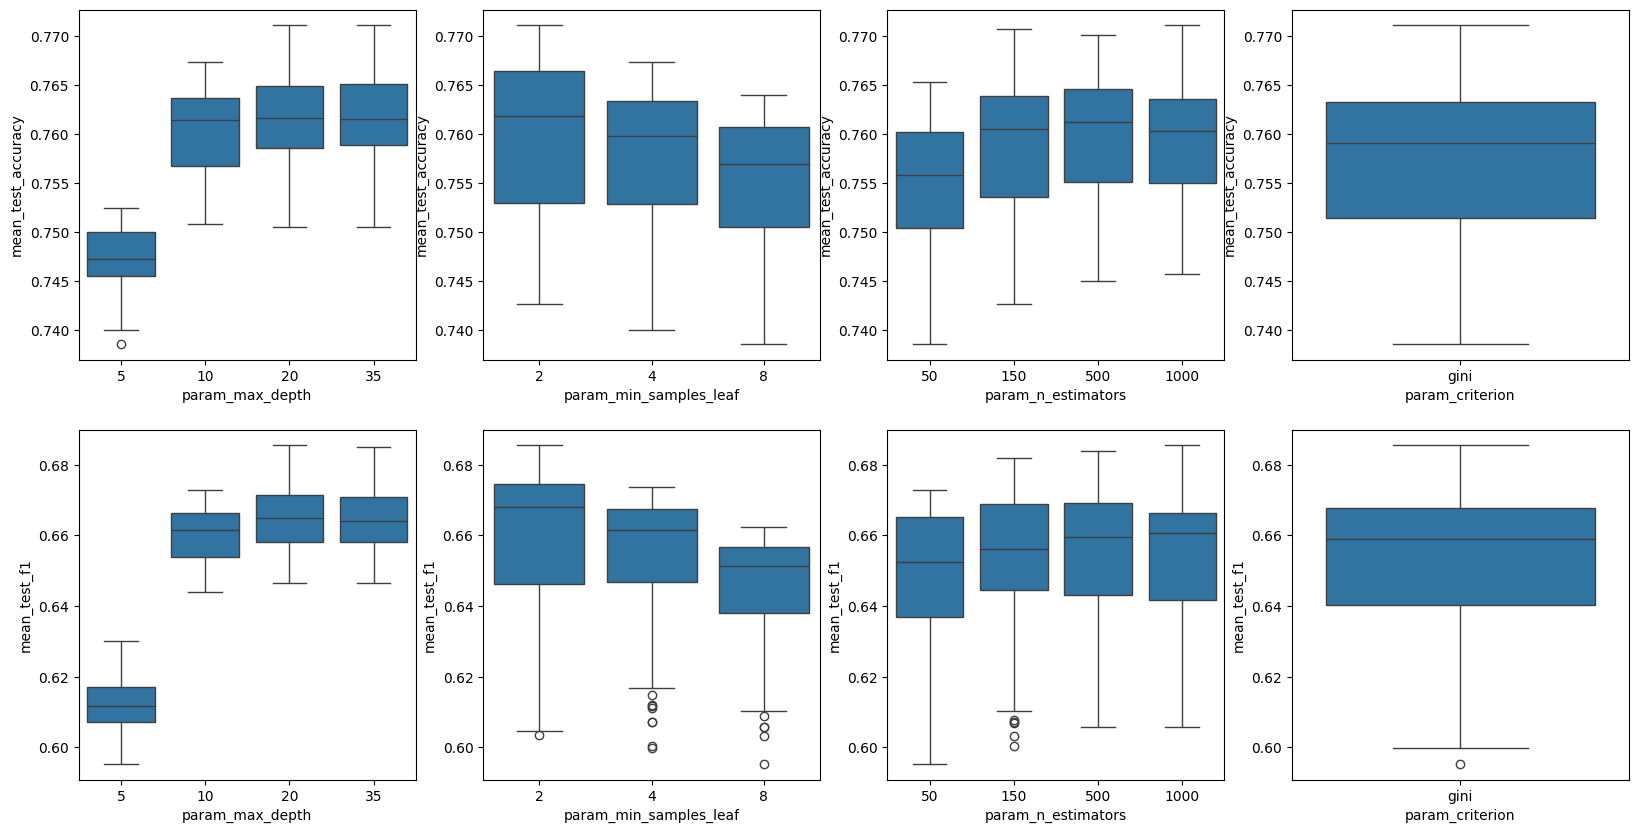

In [25]:
fig, ax = plt.subplots(2,4, figsize=(20,10))
sb.boxplot(data=rf_cv_results, x='param_max_depth', y='mean_test_accuracy', ax=ax[0,0])
sb.boxplot(data=rf_cv_results, x='param_min_samples_leaf', y='mean_test_accuracy', ax=ax[0,1])
sb.boxplot(data=rf_cv_results, x='param_n_estimators', y='mean_test_accuracy', ax=ax[0,2])
sb.boxplot(data=rf_cv_results, x='param_criterion', y='mean_test_accuracy', ax=ax[0,3])
sb.boxplot(data=rf_cv_results, x='param_max_depth', y='mean_test_f1', ax=ax[1,0])
sb.boxplot(data=rf_cv_results, x='param_min_samples_leaf', y='mean_test_f1', ax=ax[1,1])
sb.boxplot(data=rf_cv_results, x='param_n_estimators', y='mean_test_f1', ax=ax[1,2])
sb.boxplot(data=rf_cv_results, x='param_criterion', y='mean_test_f1', ax=ax[1,3])

In [ ]:
# kun demo av at criterion ikke i gir betydelig effekt


rf_params = {
    'max_depth': [10, 20, 35],
    'min_samples_leaf': [2, 4, 8],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [250, 500, 1000],
}
rf_estimators, rf_scores_train, rf_scores_test, rf_cv_results = train(df_features, df_targets,
    RandomForestClassifier(random_state=global_random_state),
    rf_params, outer_splits=3, inner_splits=3)

In [56]:
rf_params = {
    'max_depth': [20],
    'min_samples_leaf': [2],
    'min_samples_split': [4],
    'criterion': ['gini'],
    'n_estimators': [500],
}
rf_estimators_final, rf_scores_train_final, rf_scores_test_final, rf_cv_results_final = train(df_features, df_targets,
    RandomForestClassifier(random_state=global_random_state),
    rf_params, outer_splits=5, inner_splits=4)

*
*
*
*
*


gradiens

In [26]:
gb_params = {
    "n_estimators": [250, 500, 1000],
    "learning_rate": [0.0001, 0.001, 0.1],
    'min_samples_split': [6, 12, 20], 
    'max_depth': [2, 6, 12],
   
}

gb_estimators, gb_scores_train, gb_scores_test, gb_cv_results = train(df_features, df_targets,
    GradientBoostingClassifier(random_state=global_random_state),
    gb_params, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_n_estimators', ylabel='mean_test_f1'>

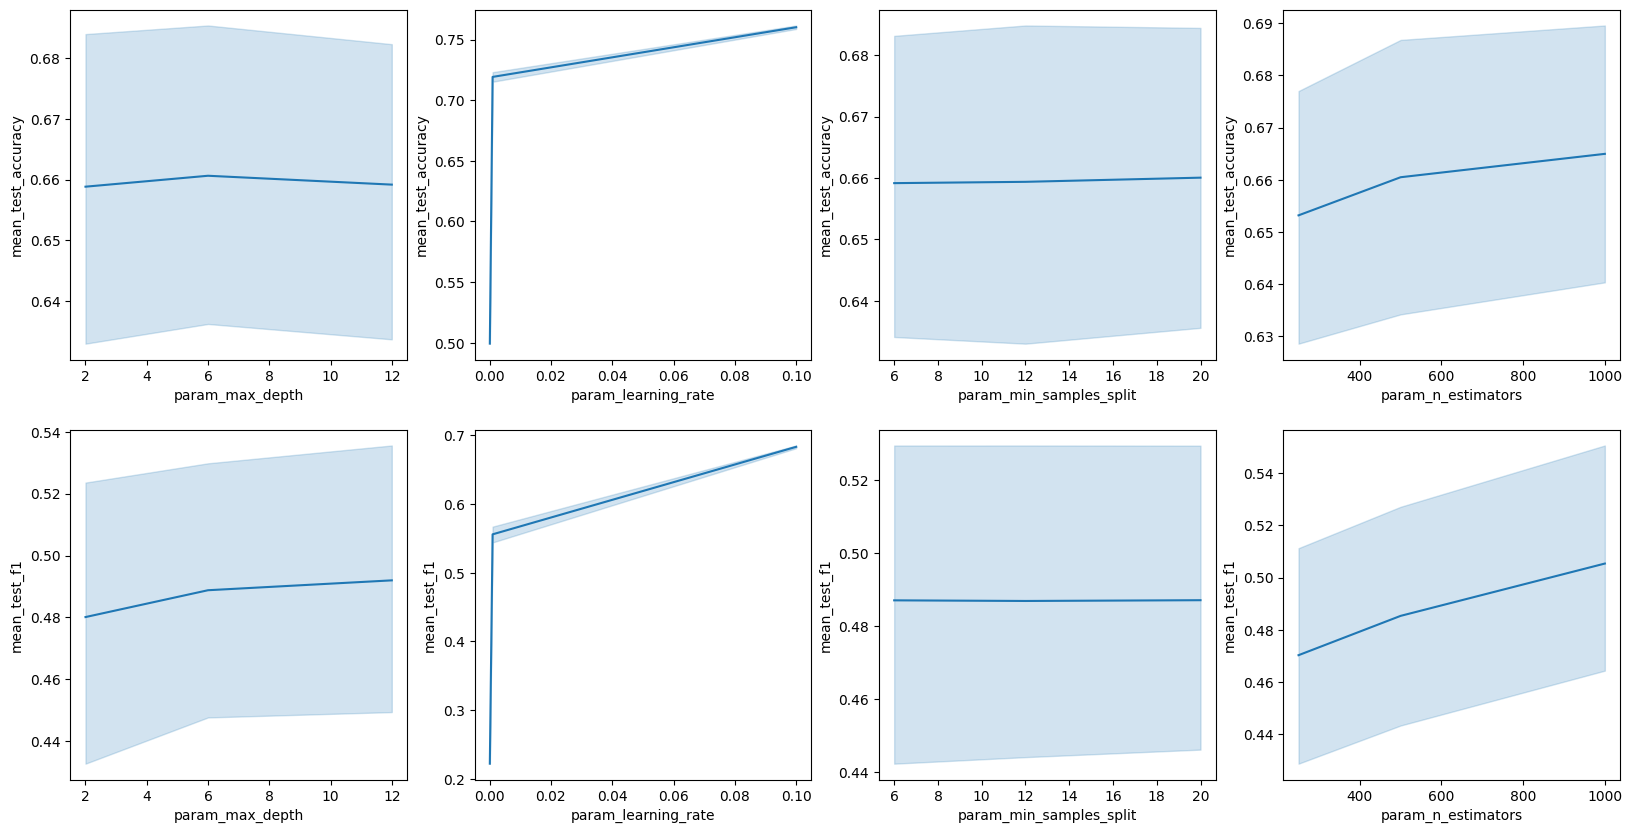

In [30]:
fig, ax = plt.subplots(2,4, figsize=(20,10))
sb.lineplot(data=gb_cv_results, x='param_max_depth', y='mean_test_accuracy', ax=ax[0,0])
sb.lineplot(data=gb_cv_results, x='param_learning_rate', y='mean_test_accuracy', ax=ax[0,1])
sb.lineplot(data=gb_cv_results, x='param_min_samples_split', y='mean_test_accuracy', ax=ax[0,2])
sb.lineplot(data=gb_cv_results, x='param_n_estimators', y='mean_test_accuracy', ax=ax[0,3])
sb.lineplot(data=gb_cv_results, x='param_max_depth', y='mean_test_f1', ax=ax[1,0])
sb.lineplot(data=gb_cv_results, x='param_learning_rate', y='mean_test_f1', ax=ax[1,1])
sb.lineplot(data=gb_cv_results, x='param_min_samples_split', y='mean_test_f1', ax=ax[1,2])
sb.lineplot(data=gb_cv_results, x='param_n_estimators', y='mean_test_f1', ax=ax[1,3])

In [ ]:
gb_params = {
    "n_estimators": [250, 500, 1000],
    "learning_rate": [0.1],
    'min_samples_split': [6, 12, 20], 
    'max_depth': [2, 6, 12],
   
}

gb_estimators_2, gb_scores_train_2, gb_scores_test_2, gb_cv_results_2 = train(df_features, df_targets,
    GradientBoostingClassifier(random_state=global_random_state),
    gb_params, outer_splits=3, inner_splits=3)

In [17]:
gb_scores_train.describe()

,accuracy,precision,recall,f1,roc_auc
count,3.0,3.0,3.0,3.0,3.0
mean,1.0,1.0,1.0,1.0,1.0
std,0.0,0.0,0.0,0.0,0.0
min,1.0,1.0,1.0,1.0,1.0
25%,1.0,1.0,1.0,1.0,1.0
50%,1.0,1.0,1.0,1.0,1.0
75%,1.0,1.0,1.0,1.0,1.0
max,1.0,1.0,1.0,1.0,1.0


In [18]:
gb_scores_test.describe()

,accuracy,precision,recall,f1,roc_auc
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.768765,0.715885,0.692443,0.700629,0.881028
std,0.014023,0.019620,0.012464,0.014690,0.006960
min,0.760000,0.700336,0.682395,0.688561,0.873497
25%,0.760678,0.704863,0.685469,0.692450,0.877932
50%,0.761356,0.709389,0.688543,0.696339,0.882367
75%,0.773147,0.723659,0.697467,0.706662,0.884794
max,0.784939,0.737929,0.706390,0.716985,0.887222


In [20]:
print_estimators(gb_estimators)

GradientBoostingClassifier(max_depth=4, min_samples_split=4, n_estimators=500,
                           random_state=15, subsample=0.5)
GradientBoostingClassifier(max_depth=4, min_samples_split=4, n_estimators=500,
                           random_state=15, subsample=0.5)
GradientBoostingClassifier(max_depth=4, min_samples_split=4, n_estimators=500,
                           random_state=15, subsample=0.5)


In [ ]:
gb_params = {
    "n_estimators": [500, 1000],
    "learning_rate": [0.1, 0.2],
    'subsample': [0.5, 0.75],
    'min_samples_split': [4, 8], 
    'max_depth': [2, 4],   
}

gb_estimators_2, gb_scores_train_2, gb_scores_test_2, gb_cv_results_2 = train(df_features, df_targets,
    GradientBoostingClassifier(random_state=global_random_state),
    gb_params, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_subsample', ylabel='mean_test_f1'>

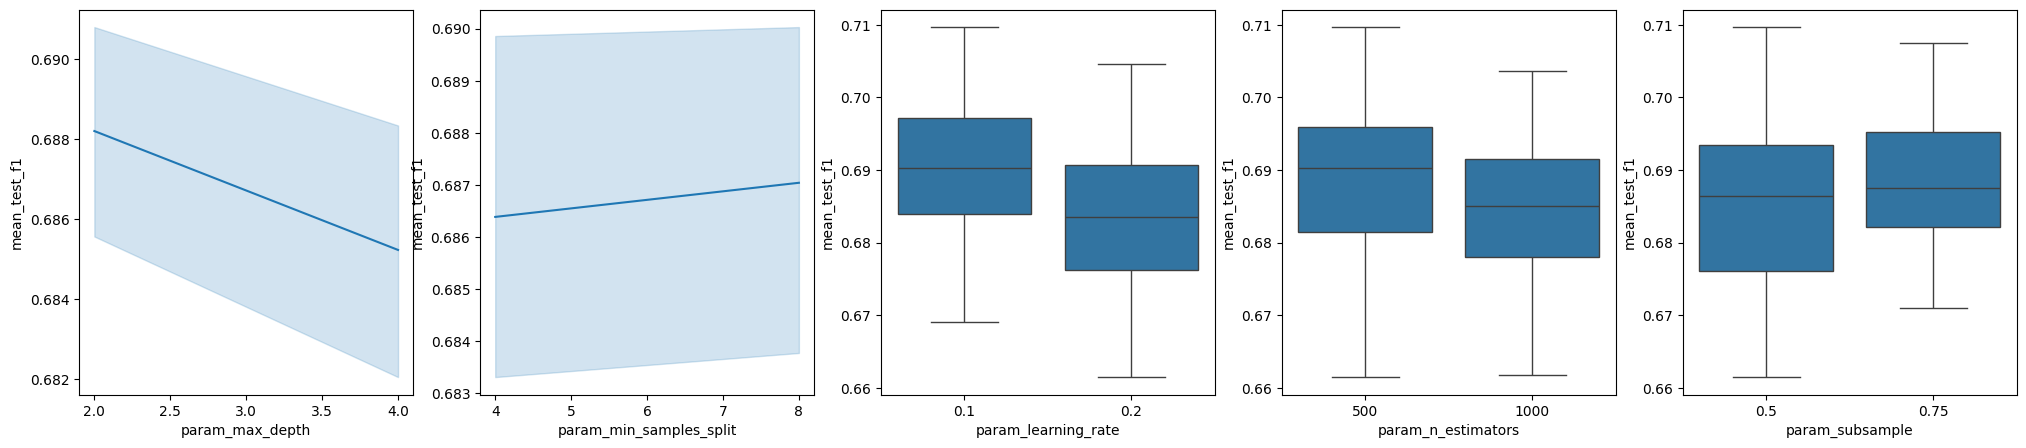

In [31]:
fig, ax = plt.subplots(1,5, figsize=(25,5))
sb.lineplot(data=gb_cv_results_2, x='param_max_depth', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=gb_cv_results_2, x='param_min_samples_split', y='mean_test_f1', ax=ax[1])
sb.boxplot(data=gb_cv_results_2, x='param_learning_rate', y='mean_test_f1', ax=ax[2])
sb.boxplot(data=gb_cv_results_2, x='param_n_estimators', y='mean_test_f1', ax=ax[3])
sb.boxplot(data=gb_cv_results_2, x='param_subsample', y='mean_test_f1', ax=ax[4])

In [34]:
gb_scores_test_2.describe()

,accuracy,precision,recall,f1,roc_auc
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.772606,0.718655,0.693265,0.701586,0.885217
std,0.008662,0.010227,0.004392,0.005320,0.008406
min,0.765424,0.709096,0.689243,0.698506,0.876349
25%,0.767797,0.713263,0.690922,0.698514,0.881291
50%,0.770169,0.717429,0.692601,0.698523,0.886233
75%,0.776197,0.723434,0.695276,0.703126,0.889651
max,0.782225,0.729440,0.697952,0.707729,0.893069


In [36]:
gb_scores_train_2.describe()

,accuracy,precision,recall,f1,roc_auc
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.889693,0.882585,0.844163,0.859796,0.971834
std,0.006279,0.006059,0.007644,0.006872,0.001635
min,0.882712,0.878528,0.835819,0.852862,0.970241
25%,0.887100,0.879102,0.840832,0.856392,0.970997
50%,0.891489,0.879676,0.845845,0.859921,0.971752
75%,0.893184,0.884613,0.848336,0.863263,0.972630
max,0.894880,0.889550,0.850827,0.866604,0.973509


In [37]:
gb_estimators_2

[GradientBoostingClassifier(max_depth=2, min_samples_split=4, n_estimators=500,
                            random_state=15, subsample=0.5),
 GradientBoostingClassifier(max_depth=2, min_samples_split=8, n_estimators=500,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_split=4, n_estimators=500,
                            random_state=15, subsample=0.75)]

In [38]:
gb_params = {
    "n_estimators": [250, 500],
    "learning_rate": [0.1],
    'subsample': [0.75, 0.85],
    'min_samples_split': [8, 16], 
    'max_depth': [2],   
}

gb_estimators_3, gb_scores_train_3, gb_scores_test_3, gb_cv_results_3 = train(df_features, df_targets,
    GradientBoostingClassifier(random_state=global_random_state),
    gb_params, outer_splits=3, inner_splits=3)

*
*
*


<Axes: xlabel='param_subsample', ylabel='mean_test_f1'>

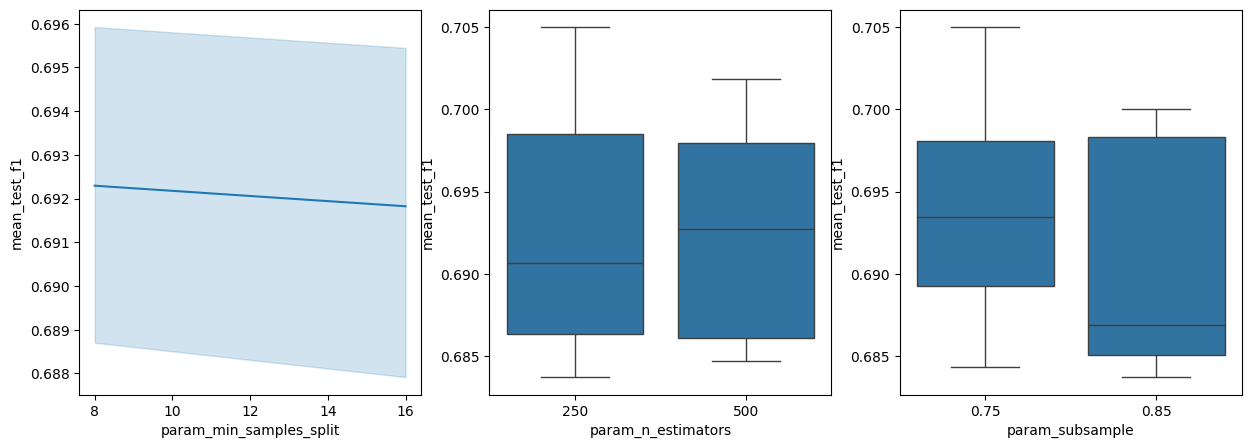

In [42]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.lineplot(data=gb_cv_results_3, x='param_min_samples_split', y='mean_test_f1', ax=ax[0])
sb.boxplot(data=gb_cv_results_3, x='param_n_estimators', y='mean_test_f1', ax=ax[1])
sb.boxplot(data=gb_cv_results_3, x='param_subsample', y='mean_test_f1', ax=ax[2])

In [44]:
gb_scores_test_3.describe()

,accuracy,precision,recall,f1,roc_auc
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.770573,0.714597,0.689372,0.697413,0.885359
std,0.012460,0.015057,0.009555,0.010704,0.007104
min,0.762712,0.703850,0.681392,0.690043,0.878815
25%,0.763390,0.705992,0.684078,0.691273,0.881581
50%,0.764068,0.708134,0.686764,0.692504,0.884348
75%,0.774503,0.719970,0.693362,0.701097,0.888631
max,0.784939,0.731807,0.699960,0.709691,0.892914


In [45]:
gb_scores_train_3.describe()

,accuracy,precision,recall,f1,roc_auc
count,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.875451,0.864855,0.826050,0.841604,0.964374
std,0.023465,0.032496,0.030989,0.031893,0.012260
min,0.848762,0.827444,0.790676,0.805056,0.950272
25%,0.866754,0.854254,0.814870,0.830509,0.960313
50%,0.884746,0.881064,0.839065,0.855961,0.970354
75%,0.888795,0.883561,0.843737,0.859879,0.971425
max,0.892845,0.886059,0.848410,0.863796,0.972496


In [46]:
gb_estimators_3

[GradientBoostingClassifier(max_depth=2, min_samples_split=8, n_estimators=250,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_split=16, n_estimators=500,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_split=8, n_estimators=500,
                            random_state=15, subsample=0.75)]

In [ ]:
gb_params = {
    "n_estimators": [500],
    "learning_rate": [0.1],
    'subsample': [0.75],
    'min_samples_split': [8, 12], 
    'max_depth': [2],   
}

gb_estimators_4, gb_scores_train_4, gb_scores_test_4, gb_cv_results_4 = train(df_features, df_targets,
    GradientBoostingClassifier(random_state=global_random_state),
    gb_params, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_min_samples_split', ylabel='mean_test_f1'>

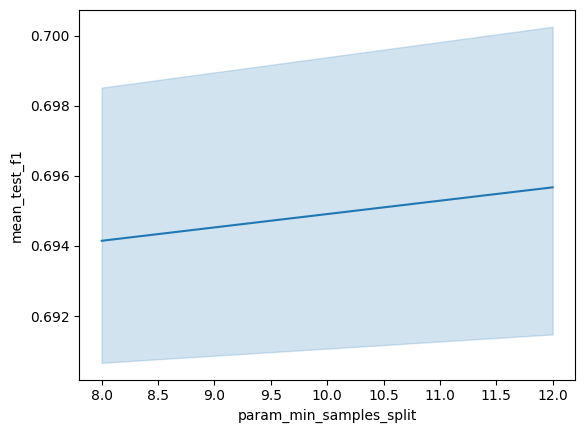

In [48]:
sb.lineplot(data=gb_cv_results_4, x='param_min_samples_split', y='mean_test_f1')

In [50]:
gb_scores_test_4.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.778936,0.727845,0.700005,0.709118,0.889834
std,0.012383,0.018881,0.011330,0.013720,0.005532
min,0.762712,0.705406,0.686979,0.695321,0.884980
25%,0.774011,0.716742,0.691706,0.696679,0.885892
50%,0.775141,0.722565,0.698072,0.706966,0.887076
75%,0.790960,0.744280,0.711029,0.722890,0.893498
max,0.791855,0.750234,0.712238,0.723732,0.897726


In [51]:
gb_scores_train_4.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.876187,0.865271,0.826953,0.842325,0.965792
std,0.002620,0.002560,0.004885,0.004152,0.000895
min,0.872563,0.863161,0.818997,0.835956,0.964543
25%,0.875141,0.863513,0.826616,0.841583,0.965318
50%,0.876236,0.864184,0.827839,0.842579,0.966096
75%,0.877366,0.866133,0.829277,0.844285,0.966099
max,0.879627,0.869364,0.832038,0.847220,0.966903


In [52]:
gb_estimators_4

[GradientBoostingClassifier(max_depth=2, min_samples_split=12, n_estimators=500,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_split=12, n_estimators=500,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_split=8, n_estimators=500,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_split=12, n_estimators=500,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_split=12, n_estimators=500,
                            random_state=15, subsample=0.75)]

In [90]:
gb_params = {
    "n_estimators": [500],
    "learning_rate": [0.1],
    'subsample': [0.75],
    'min_samples_split': [12],
    'min_samples_leaf':[4, 8, 12], 
    'max_depth': [2],   
}

gb_estimators_5, gb_scores_train_5, gb_scores_test_5, gb_cv_results_5 = train(df_features, df_targets,
    GradientBoostingClassifier(random_state=global_random_state),
    gb_params, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_min_samples_leaf', ylabel='mean_test_f1'>

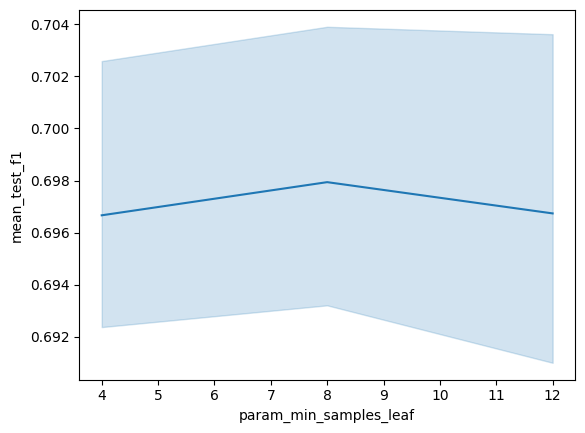

In [91]:
sb.lineplot(data=gb_cv_results_5, x='param_min_samples_leaf', y='mean_test_f1')

In [95]:
gb_scores_test_5.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.781197,0.731740,0.702221,0.711815,0.889548
std,0.014023,0.023470,0.014583,0.017206,0.005341
min,0.769492,0.711943,0.687078,0.695497,0.884511
25%,0.771751,0.713858,0.693880,0.700271,0.885693
50%,0.771751,0.718277,0.694805,0.702675,0.887736
75%,0.795249,0.756173,0.714550,0.727439,0.892323
max,0.797740,0.758448,0.720790,0.733194,0.897479


In [94]:
gb_scores_train_5

,accuracy,precision,recall,f1,roc_auc
0,0.875389,0.866557,0.824340,0.840962,0.965302
1,0.876801,0.865594,0.827021,0.842545,0.965342
2,0.874541,0.861603,0.827216,0.841341,0.965496
3,0.875106,0.867014,0.823421,0.840251,0.964059
4,0.876554,0.866176,0.826657,0.842466,0.963951


In [93]:
gb_estimators_5

[GradientBoostingClassifier(max_depth=2, min_samples_leaf=12,
                            min_samples_split=12, n_estimators=500,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_leaf=4,
                            min_samples_split=12, n_estimators=500,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_leaf=8,
                            min_samples_split=12, n_estimators=500,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_leaf=12,
                            min_samples_split=12, n_estimators=500,
                            random_state=15, subsample=0.75),
 GradientBoostingClassifier(max_depth=2, min_samples_leaf=4,
                            min_samples_split=12, n_estimators=500,
                            random_state=15, subsample=0.75)]

In [96]:
gb_params = {
    "n_estimators": [500],
    "learning_rate": [0.1],
    'subsample': [0.75],
    'min_samples_split': [12],
    'min_samples_leaf':[8], 
    'max_depth': [2],   
}

gb_estimators_final, gb_scores_train_final, gb_scores_test_final, gb_cv_results_final = train(df_features, df_targets,
    GradientBoostingClassifier(random_state=global_random_state),
    gb_params, outer_splits=5, inner_splits=4)

*
*
*
*
*


In [98]:
gb_scores_test_final.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.781196,0.730474,0.702742,0.711932,0.889266
std,0.011078,0.017775,0.010967,0.013158,0.005419
min,0.769492,0.711943,0.688832,0.697138,0.884370
25%,0.771751,0.714721,0.694805,0.700271,0.885693
50%,0.779661,0.728682,0.703521,0.712648,0.886880
75%,0.790960,0.745480,0.712238,0.723080,0.891859
max,0.794118,0.751543,0.714313,0.726523,0.897529


In [100]:
gb_scores_train_final.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.874605,0.864110,0.824773,0.840474,0.964888
std,0.002997,0.004750,0.003896,0.003952,0.000965
min,0.869492,0.857188,0.818443,0.833909,0.963341
25%,0.874541,0.861603,0.824346,0.841215,0.964538
50%,0.875954,0.865214,0.825319,0.841252,0.965460
75%,0.875954,0.867975,0.827216,0.841341,0.965496
max,0.877084,0.868571,0.828542,0.844654,0.965604


LR

In [ ]:
lr_params = {
    'C': [0.01, 0.1, 1, 1.5, 5, 10],
    "solver": ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"],   
    'tol': [1e-2, 1e-3, 1e-4, 1e-5],
    'max_iter': [100],
}

lr_estimators, lr_scores_train, lr_scores_test, lr_cv_results = train(df_features, df_targets,
    LogisticRegression(random_state=global_random_state),
    lr_params, outer_splits=5, inner_splits=4)

<Axes: xlabel='param_solver', ylabel='mean_test_f1'>

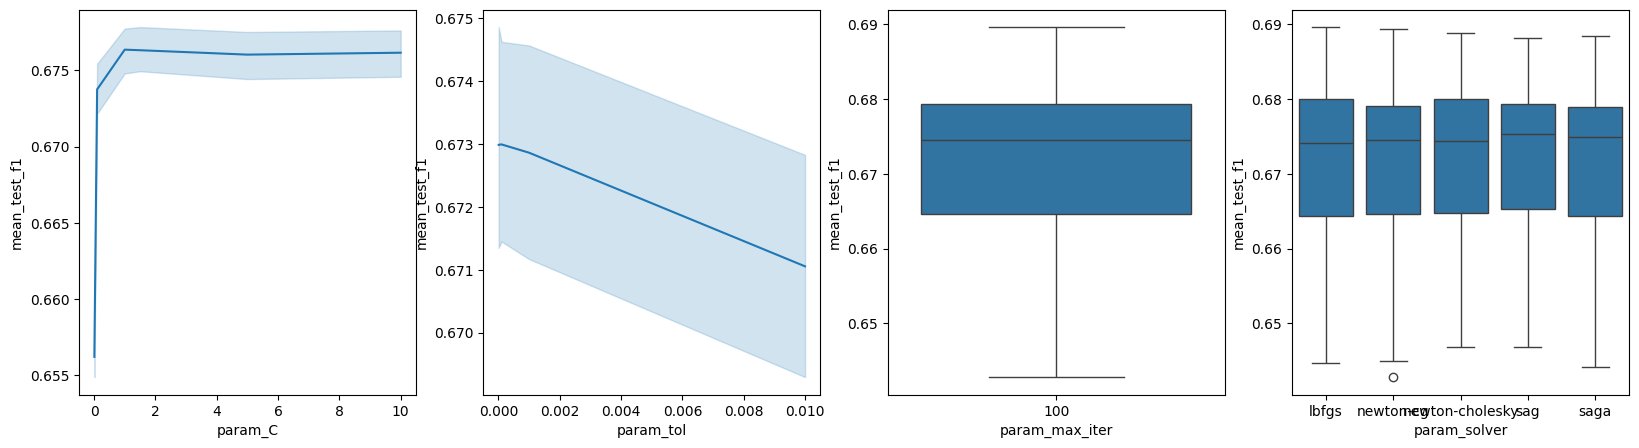

In [62]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
sb.lineplot(data=lr_cv_results, x='param_C', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=lr_cv_results, x='param_tol', y='mean_test_f1', ax=ax[1])
sb.boxplot(data=lr_cv_results, x='param_max_iter', y='mean_test_f1', ax=ax[2])
sb.boxplot(data=lr_cv_results, x='param_solver', y='mean_test_f1', ax=ax[3])

In [60]:
lr_scores_test.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.765372,0.707594,0.668221,0.676151,0.880329
std,0.013010,0.019314,0.013443,0.014171,0.005605
min,0.744633,0.676538,0.647256,0.654383,0.870457
25%,0.760452,0.705416,0.663436,0.671777,0.881511
50%,0.772624,0.713037,0.672873,0.680654,0.882548
75%,0.774011,0.714173,0.675926,0.681680,0.882869
max,0.775141,0.728806,0.681617,0.692259,0.884259


In [61]:
lr_scores_train.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.775204,0.721149,0.680511,0.689531,0.890374
std,0.003806,0.006750,0.005205,0.006104,0.000987
min,0.770621,0.714039,0.675290,0.683672,0.889536
25%,0.773100,0.715898,0.676762,0.684543,0.889562
50%,0.774513,0.721329,0.680348,0.689993,0.890364
75%,0.777338,0.723372,0.681517,0.690497,0.890444
max,0.780446,0.731105,0.688636,0.698949,0.891964


In [63]:
print_estimators(lr_estimators)

LogisticRegression(C=1, random_state=15, tol=0.001)
LogisticRegression(C=0.1, random_state=15, tol=0.001)
LogisticRegression(C=10, random_state=15, solver='sag', tol=0.01)
LogisticRegression(C=1, random_state=15, tol=0.001)
LogisticRegression(C=1.5, random_state=15, solver='newton-cg')


In [64]:
lr_params = {
    'C': [0.1, 1, 1.5, 5, 10],
    "solver": ["lbfgs"],   
    'tol': [1e-2, 1e-3, 1e-4],
    'max_iter': [100, 250, 500],
}

lr_estimators_2, lr_scores_train_2, lr_scores_test_2, lr_cv_results_2 = train(df_features, df_targets,
    LogisticRegression(random_state=global_random_state),
    lr_params, outer_splits=5, inner_splits=4)

*
*
*
*
*


<Axes: xlabel='param_max_iter', ylabel='mean_test_f1'>

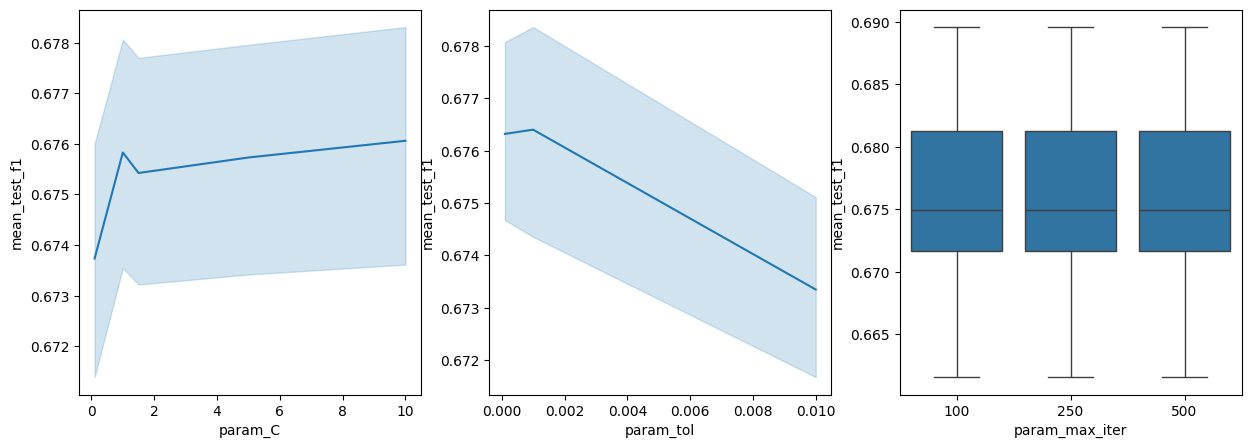

In [65]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sb.lineplot(data=lr_cv_results_2, x='param_C', y='mean_test_f1', ax=ax[0])
sb.lineplot(data=lr_cv_results_2, x='param_tol', y='mean_test_f1', ax=ax[1])
sb.boxplot(data=lr_cv_results_2, x='param_max_iter', y='mean_test_f1', ax=ax[2])

In [67]:
lr_scores_test_2.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.766051,0.708576,0.669753,0.677865,0.880379
std,0.013541,0.019743,0.014431,0.015090,0.005632
min,0.744633,0.676538,0.647256,0.654383,0.870457
25%,0.760452,0.705416,0.663436,0.671777,0.881504
50%,0.774887,0.715194,0.677092,0.685351,0.882808
75%,0.775141,0.716926,0.679364,0.685553,0.882869
max,0.775141,0.728806,0.681617,0.692259,0.884259


In [68]:
lr_scores_train_2.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.775091,0.720896,0.680389,0.689364,0.890402
std,0.003906,0.006885,0.005259,0.006154,0.000964
min,0.770339,0.713536,0.675101,0.683440,0.889562
25%,0.773100,0.715898,0.676762,0.684543,0.889646
50%,0.774230,0.720567,0.679928,0.689391,0.890397
75%,0.777338,0.723372,0.681517,0.690497,0.890444
max,0.780446,0.731105,0.688636,0.698949,0.891964


In [69]:
lr_estimators_2

[LogisticRegression(C=1, random_state=15, tol=0.001),
 LogisticRegression(C=0.1, random_state=15, tol=0.001),
 LogisticRegression(C=1, random_state=15),
 LogisticRegression(C=1, random_state=15, tol=0.001),
 LogisticRegression(C=10, random_state=15)]

In [70]:
lr_params = {
    'C': [1],
    "solver": ["lbfgs"],   
    'tol': [1e-3],
    'max_iter': [100],
}

lr_estimators_final, lr_scores_train_final, lr_scores_test_final, lr_cv_results_final = train(df_features, df_targets,
    LogisticRegression(random_state=global_random_state),
    lr_params, outer_splits=5, inner_splits=4)

*
*
*
*
*


In [72]:
lr_scores_test_final.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.765146,0.706670,0.668607,0.676385,0.880766
std,0.011609,0.017973,0.010989,0.012055,0.005096
min,0.746893,0.678900,0.652708,0.659320,0.871795
25%,0.760452,0.705416,0.663436,0.671777,0.881716
50%,0.771493,0.708432,0.671699,0.679120,0.882869
75%,0.771751,0.711798,0.673578,0.679448,0.883191
max,0.775141,0.728806,0.681617,0.692259,0.884259


In [73]:
lr_scores_train_final.describe()

,accuracy,precision,recall,f1,roc_auc
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.774978,0.720460,0.680052,0.688816,0.890517
std,0.002950,0.005024,0.004940,0.005727,0.001370
min,0.771751,0.715635,0.675308,0.683270,0.889562
25%,0.773100,0.715898,0.676762,0.684543,0.889591
50%,0.773947,0.719994,0.678835,0.688079,0.890109
75%,0.777338,0.723372,0.681517,0.690497,0.890444
max,0.778751,0.727400,0.687841,0.697694,0.892877


In [101]:
slutt_resultat = pd.DataFrame({
    'Metric': ['Accuracy:','Precision:','Recall:', 'F1:', 'Roc_auc'],
    'RandomForest Train': [rf_scores_train_final['accuracy'].mean(),rf_scores_train_final['precision'].mean(), rf_scores_train_final['recall'].mean(), rf_scores_train_final['f1'].mean(), rf_scores_train_final['roc_auc'].mean()],
    'RandomForest Test': [rf_scores_test_final['accuracy'].mean(),rf_scores_test_final['precision'].mean(), rf_scores_test_final['recall'].mean(), rf_scores_test_final['f1'].mean(), rf_scores_test_final['roc_auc'].mean()],
    'Gradient Boosting Train': [gb_scores_train_final['accuracy'].mean(),gb_scores_train_final['precision'].mean(), gb_scores_train_final['recall'].mean(), gb_scores_train_final['f1'].mean(), gb_scores_train_final['roc_auc'].mean()],
    'Gradient Boosting Test': [gb_scores_test_final['accuracy'].mean(),gb_scores_test_final['precision'].mean(), gb_scores_test_final['recall'].mean(), gb_scores_test_final['f1'].mean(), gb_scores_test_final['roc_auc'].mean()],
    'Logistic Regression Train': [lr_scores_train_final['accuracy'].mean(),lr_scores_train_final['precision'].mean(), lr_scores_train_final['recall'].mean(), lr_scores_train_final['f1'].mean(), lr_scores_train_final['roc_auc'].mean()],
    'Logistic Regression Test': [lr_scores_test_final['accuracy'].mean(),lr_scores_test_final['precision'].mean(), lr_scores_test_final['recall'].mean(), lr_scores_test_final['f1'].mean(), lr_scores_test_final['roc_auc'].mean()]
    })
slutt_resultat.set_index('Metric', inplace=True)
slutt_resultat

,RandomForest Train,RandomForest Test,Gradient Boosting Train,Gradient Boosting Test,Logistic Regression Train,Logistic Regression Test
Metric,,,,,,
Accuracy:,0.968976,0.778934,0.874605,0.781196,0.774978,0.765146
Precision:,0.977764,0.738182,0.864110,0.730474,0.720460,0.706670
Recall:,0.953909,0.688615,0.824773,0.702742,0.680052,0.668607
F1:,0.964795,0.700557,0.840474,0.711932,0.688816,0.676385
Roc_auc,0.999201,0.890295,0.964888,0.889266,0.890517,0.880766


In [5]:
def split_targets_and_features(data):
    targets = data['Target']
    features = pd.DataFrame(StandardScaler().fit_transform(data.drop("Target", axis=1)), columns=data.drop("Target", axis=1).columns)
    
    return [features, targets]

def split_dataset(data):
    data['Target'] = pd.Series(np.array(LabelEncoder().fit_transform(data['Target'])))
    train = data.groupby("Target", group_keys=False)[df.columns].sample(frac=0.8)
    test = data.drop(train.index)
    train = split_targets_and_features(train)
    test = split_targets_and_features(test)

    return train, test

slutt_train, slutt_test = split_dataset(df)

In [16]:
gb_params = {
    "n_estimators": [500],
    "learning_rate": [0.1],
    'subsample': [0.75],
    'min_samples_split': [12],
    'min_samples_leaf' 
    'max_depth': [2],   
}


gb_model = GradientBoostingClassifier(max_depth=2, min_samples_leaf=8, min_samples_split=12, subsample=0.75, n_estimators=500, learning_rate=0.1)
gb_model.fit(slutt_train[0], slutt_train[1])

gb_model_pred = gb_model.predict_proba(slutt_test[0])
unik_tr = np.unique(gb_model_pred[:,0])
for threshold in unik_tr:
    threshold_predictions = (gb_model_pred[:,0] < threshold)*1

    precision = precision_score(slutt_test[1], threshold_predictions, zero_division=1, average='macro')
    recall = recall_score(slutt_test[1], threshold_predictions, average='macro')

    print(f'Threshold: {threshold:.3f} Precision: {precision:.3f} Recall: {recall:.3f}')

Threshold: 0.001 Precision: 0.774 Recall: 0.333
Threshold: 0.003 Precision: 0.440 Recall: 0.333
Threshold: 0.003 Precision: 0.441 Recall: 0.333
Threshold: 0.003 Precision: 0.441 Recall: 0.333
Threshold: 0.003 Precision: 0.441 Recall: 0.333
Threshold: 0.003 Precision: 0.441 Recall: 0.333
Threshold: 0.003 Precision: 0.441 Recall: 0.333
Threshold: 0.004 Precision: 0.441 Recall: 0.333
Threshold: 0.004 Precision: 0.441 Recall: 0.333
Threshold: 0.004 Precision: 0.441 Recall: 0.333
Threshold: 0.004 Precision: 0.442 Recall: 0.333
Threshold: 0.004 Precision: 0.442 Recall: 0.333
Threshold: 0.004 Precision: 0.442 Recall: 0.333
Threshold: 0.005 Precision: 0.442 Recall: 0.333
Threshold: 0.005 Precision: 0.442 Recall: 0.333
Threshold: 0.005 Precision: 0.442 Recall: 0.333
Threshold: 0.005 Precision: 0.463 Recall: 0.335
Threshold: 0.005 Precision: 0.462 Recall: 0.335
Threshold: 0.005 Precision: 0.461 Recall: 0.335
Threshold: 0.005 Precision: 0.460 Recall: 0.335
Threshold: 0.005 Precision: 0.459 Recall

In [11]:
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
   def __init__(self, estimator, threshold=0.5): 
       self.estimator = estimator
       self.threshold = threshold

   def fit(self, X, y):
       if hasattr(self.estimator, 'classes_'):
            self.classes_ = self.estimator.classes_
            return self
       self.estimator.fit(X, y)
       return self

   def predict(self, X):
    #    proba = self.estimator.predict_proba(X)[:, 1]
       proba = self.estimator.predict_proba(X)[:, 0]
       return (proba < self.threshold).astype(int)

   def predict_proba(self, X):
       return self.estimator.predict_proba(X)

In [20]:
gb_threshold = ThresholdClassifier(estimator=gb_model, threshold=0.96)
gb_threshold.fit(slutt_train[0], slutt_train[1])
predictions = gb_threshold.predict(slutt_test[0])
print(f'Precision: {precision_score(slutt_test[1], predictions, zero_division=1, average='macro'):.3f}')
print(f'Recall: {recall_score(slutt_test[1], predictions, average='macro'):.3f}')


Precision: 0.730
Recall: 0.440
